
# CryptoPredictor: An LSTM-Based Bitcoin Price Forecasting Model

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Descargar datos del Bitcoin desde 2009
symbol = "BTC-USD"  # Bitcoin en dólares
data = yf.download(symbol, start="2009-01-01", end="2024-01-01", interval="1d")

# Visualizar los primeros datos
print(data.head())

# Guardar los datos en un archivo CSV (opcional)
data.to_csv("bitcoin_data.csv")

[*********************100%***********************]  1 of 1 completed

Price        Adj Close       Close        High         Low        Open  \
Ticker         BTC-USD     BTC-USD     BTC-USD     BTC-USD     BTC-USD   
Date                                                                     
2014-09-17  457.334015  457.334015  468.174011  452.421997  465.864014   
2014-09-18  424.440002  424.440002  456.859985  413.104004  456.859985   
2014-09-19  394.795990  394.795990  427.834991  384.532013  424.102997   
2014-09-20  408.903992  408.903992  423.295990  389.882996  394.673004   
2014-09-21  398.821014  398.821014  412.425995  393.181000  408.084991   

Price         Volume  
Ticker       BTC-USD  
Date                  
2014-09-17  21056800  
2014-09-18  34483200  
2014-09-19  37919700  
2014-09-20  36863600  
2014-09-21  26580100  


In [ ]:
# Cargar datos (si ya está guardado en CSV)
# data = pd.read_csv("bitcoin_data.csv", index_col="Date", parse_dates=True)

# Manejar valores faltantes
data = data.dropna()

# Seleccionar precios de cierre
prices = data['Close'].values.reshape(-1, 1)

print(f"Datos cargados: {prices.shape[0]} registros disponibles.")


Datos cargados: 3393 registros disponibles.


In [ ]:
# Normalizar precios
scaler = MinMaxScaler()
prices_scaled = scaler.fit_transform(prices)

# Crear secuencias de tiempo
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 60  # Predicción basada en los últimos 60 días
X, y = create_sequences(prices_scaled, seq_length)

# Dividir en datos de entrenamiento y prueba (80%-20%)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"Conjunto de entrenamiento: {X_train.shape}")
print(f"Conjunto de prueba: {X_test.shape}")



Conjunto de entrenamiento: (2666, 60, 1)
Conjunto de prueba: (667, 60, 1)


In [ ]:
# Construir el modelo
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)  # Predicción del siguiente valor
])

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

print(model.summary())


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.0165 - val_loss: 0.0012
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0017 - val_loss: 9.0870e-04
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0013 - val_loss: 6.6793e-04
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0013 - val_loss: 6.8591e-04
Epoch 5/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 6/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0013 - val_loss: 6.1037e-04
Epoch 7/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0012 - val_loss: 5.9269e-04
Epoch 8/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0012 - val_loss: 4.9854e-04
Epoch 9/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0012 - val_loss: 5.3880e-04
Epoch 10/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0012 - val_loss: 5.2765e-04
Epoch 11/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0010 - val_loss: 4.4062e-04
Epoch 12/50
84/84 ━━━━━━━━━━━━━━━━━

In [ ]:
# Predicciones en el conjunto de prueba
y_pred = model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

# Generar fechas para el eje X
dates = data.index[-len(y_test_rescaled):]  # Tomar las fechas del conjunto de prueba


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


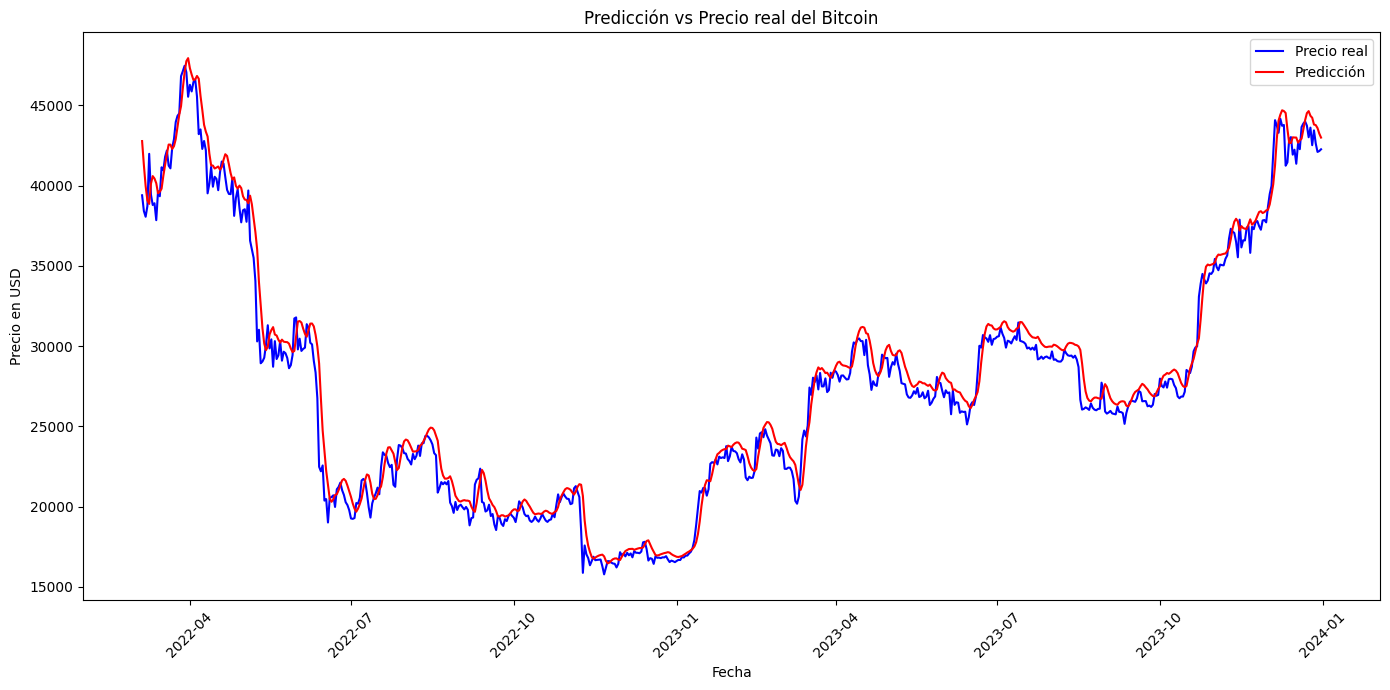

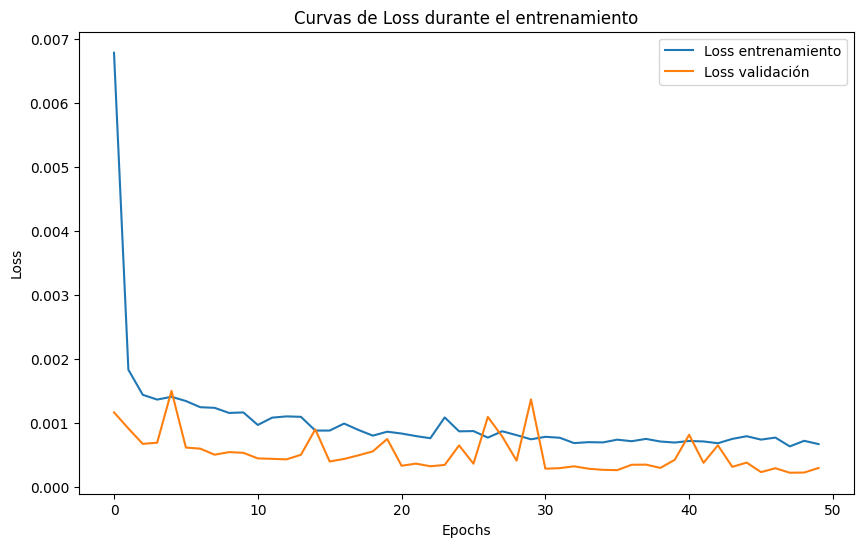

In [ ]:
# Visualizar los resultados
plt.figure(figsize=(14, 7))

# Graficar el precio real y las predicciones
plt.plot(dates, y_test_rescaled, label="Precio real", color="blue")
plt.plot(dates, y_pred_rescaled, label="Predicción", color="red")

# Configuración del gráfico
plt.legend()
plt.title("Predicción vs Precio real del Bitcoin")
plt.xlabel("Fecha")
plt.ylabel("Precio en USD")

# Ajustar la visualización del eje X para mejorar la legibilidad (mostrar fechas)
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

# Graficar la curva de entrenamiento y validación para observar el "loss"
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Loss entrenamiento')
plt.plot(history.history['val_loss'], label='Loss validación')
plt.title('Curvas de Loss durante el entrenamiento')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()